In [1]:
import os
# this allows for parallelization with pmap.
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(200)
import jax
import jax.numpy as jnp
import sys
sys.path.append('src/')
from nn import MLP, train
import numpy as np
import matplotlib.pyplot as plt
import optax 
import scipy
from functools import partial
from path_sampling import dfdt, div_f, update, update_non_amortized
from path_sampling import make_double_well_potential, sample_sde


We now define a function that generates random paths given a drift term `b` and a noise term `W`:

## Example of Algorithm 1: with $b = -\nabla V$


In [8]:
potential = make_double_well_potential(v=5.0)

def uref(x, t): 
    return -jax.grad(potential)(x)


s:  0.0
Train loss: 39813.2265625
Test loss is 39457.8359375
s:  0.1
Train loss: 33670.765625
Test loss is 34154.80859375
s:  0.5
Train loss: 7468.27294921875
Test loss is 8425.958984375


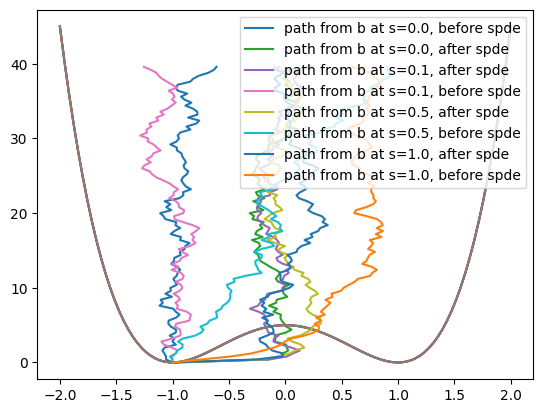

In [3]:
key = jax.random.key(0)
schedule = [0.1, 0.5, 1.0]


# currently we're just doing an SDE on \mathbb{R}
ndims = 1

b = lambda x, t: -jax.grad(make_double_well_potential(v=5.0))(x)
A = 0
dbds = MLP([3,20,20,1], key=jax.random.key(0))
for i, s in enumerate(schedule):


    key = jax.random.fold_in(key, i)

    # update b -> b + dbds
    b, A = update_non_amortized(
        V=make_double_well_potential(v=5.0),
        b=b,
        J=lambda x,y: (1/0.1**2)*(x[-1,0]- 1)**2,
        dbds=dbds,
        hyperparams={'dt': 0.001, 'num_steps': 100, 'num_training_steps' : 1000, 'batch_size' :200},
        key=key,
        schedule=schedule,
        i=i,
        prior='sde_prior',
        A=A,
        refine=True,
        ndims=ndims
    )